# Goals

* Summarize the tissues and tissue categorizations

In [1]:
from dotenv import load_dotenv
load_dotenv(override=True)

True

In [2]:
import os
import pandas as pd
import plotnine as pn
from pypika import Query, Table, Field, Column, Criterion

In [7]:
from SRAgent.db.connect import db_connect
from SRAgent.db.utils import db_list_tables

In [8]:
# set plotnine theme to bw
pn.theme_set(pn.theme_bw())

In [9]:
# set to prod database
os.environ['DYNACONF'] = 'prod'

In [10]:
# list database tables
with db_connect() as conn:
    print("\n".join(db_list_tables(conn)))

screcounter_star_results
eval
scbasecamp_metadata
screcounter_trace
srx_srr
srx_metadata
screcounter_log
scbasecamp_metadata_tmp
screcounter_star_params


# Load

In [79]:
# load database metadata
tbl1 = Table("srx_metadata")
tbl2 = Table("screcounter_star_results")

# Create a subquery for distinct SRX accessions from scbasecamp_metadata
subquery = Query.from_(tbl2).select(tbl2.sample).distinct()

stmt = (
    Query
    .from_(tbl1)
    .select(
        tbl1.srx_accession, tbl1.organism, tbl1.tissue, tbl1.tissue_ontology_term_id,
        tbl1.lib_prep, tbl1.tech_10x, tbl1.czi_collection_id
    )
    .where(tbl1.srx_accession.isin(subquery))
)

with db_connect() as conn:
    df_srx_meta = pd.read_sql(str(stmt), conn)
df_srx_meta

,srx_accession,organism,tissue,tissue_ontology_term_id,lib_prep,tech_10x,czi_collection_id
0,SRX22482811,Homo sapiens,blood,UBERON:0000178,10x_Genomics,5_prime_gex,None
1,SRX13824065,Mus musculus,skin,UBERON:0022295,10x_Genomics,3_prime_gex,None
2,SRX16015824,Homo sapiens,PBMCs,UBERON:0000178,10x_Genomics,3_prime_gex,None
3,SRX28608224,Homo sapiens,Blood,UBERON:0000178,10x_Genomics,3_prime_gex,None
4,SRX13814619,Homo sapiens,bronchoalveolar lavage fluid (alveolar macroph...,UBERON:0035963,10x_Genomics,3_prime_gex,None
...,...,...,...,...,...,...,...
59432,SRX6479174,Mus musculus,induced neural stem cells (iNSC),,10x_Genomics,3_prime_gex,None
59433,SRX6479131,Mus musculus,mouse embryonic fibroblasts (MEFs),,10x_Genomics,3_prime_gex,None
59434,SRX6479189,Mus musculus,mouse embryonic fibroblasts (MEFs),UBERON:0003104,10x_Genomics,3_prime_gex,None
59435,SRX6479182,Mus musculus,mouse embryonic fibroblasts (MEFs),,10x_Genomics,3_prime_gex,None


In [80]:
# update metadata info
df_srx_meta["tech_10x"] = df_srx_meta.apply(
    lambda x: "other" if x["lib_prep"] != "10x_Genomics" else x["tech_10x"], axis=1
)
df_srx_meta["lib_prep"] = "10x_Genomics"
df_srx_meta

,srx_accession,organism,tissue,tissue_ontology_term_id,lib_prep,tech_10x,czi_collection_id
0,SRX22482811,Homo sapiens,blood,UBERON:0000178,10x_Genomics,5_prime_gex,None
1,SRX13824065,Mus musculus,skin,UBERON:0022295,10x_Genomics,3_prime_gex,None
2,SRX16015824,Homo sapiens,PBMCs,UBERON:0000178,10x_Genomics,3_prime_gex,None
3,SRX28608224,Homo sapiens,Blood,UBERON:0000178,10x_Genomics,3_prime_gex,None
4,SRX13814619,Homo sapiens,bronchoalveolar lavage fluid (alveolar macroph...,UBERON:0035963,10x_Genomics,3_prime_gex,None
...,...,...,...,...,...,...,...
59432,SRX6479174,Mus musculus,induced neural stem cells (iNSC),,10x_Genomics,3_prime_gex,None
59433,SRX6479131,Mus musculus,mouse embryonic fibroblasts (MEFs),,10x_Genomics,3_prime_gex,None
59434,SRX6479189,Mus musculus,mouse embryonic fibroblasts (MEFs),UBERON:0003104,10x_Genomics,3_prime_gex,None
59435,SRX6479182,Mus musculus,mouse embryonic fibroblasts (MEFs),,10x_Genomics,3_prime_gex,None


In [81]:
# load tissue categories
df_tissue_cats = pd.read_csv("./data/2025-03-11_tissue_categories.csv")
df_tissue_cats

,tissue,category
0,2 layer spheroid,other
1,"3 layer spheroid channel 1,epithelial",other
2,3 layer spheroid channel 2,other
3,3D healthy skin model,skin of body
4,A549 cells,lung
...,...,...
5613,"whole animal, developmental stages: 26, 28, 30...",other
5614,whole skin tissue,skin of body
5615,wing,other
5616,zebrafish embryos,embryo


In [82]:
# left join on tissue
df_srx_meta = df_srx_meta.merge(df_tissue_cats, on="tissue", how="left")
df_srx_meta

,srx_accession,organism,tissue,tissue_ontology_term_id,lib_prep,tech_10x,czi_collection_id,category
0,SRX22482811,Homo sapiens,blood,UBERON:0000178,10x_Genomics,5_prime_gex,None,blood
1,SRX13824065,Mus musculus,skin,UBERON:0022295,10x_Genomics,3_prime_gex,None,skin of body
2,SRX16015824,Homo sapiens,PBMCs,UBERON:0000178,10x_Genomics,3_prime_gex,None,blood
3,SRX28608224,Homo sapiens,Blood,UBERON:0000178,10x_Genomics,3_prime_gex,None,blood
4,SRX13814619,Homo sapiens,bronchoalveolar lavage fluid (alveolar macroph...,UBERON:0035963,10x_Genomics,3_prime_gex,None,NaN
...,...,...,...,...,...,...,...,...
59432,SRX6479174,Mus musculus,induced neural stem cells (iNSC),,10x_Genomics,3_prime_gex,None,NaN
59433,SRX6479131,Mus musculus,mouse embryonic fibroblasts (MEFs),,10x_Genomics,3_prime_gex,None,embryo
59434,SRX6479189,Mus musculus,mouse embryonic fibroblasts (MEFs),UBERON:0003104,10x_Genomics,3_prime_gex,None,embryo
59435,SRX6479182,Mus musculus,mouse embryonic fibroblasts (MEFs),,10x_Genomics,3_prime_gex,None,embryo


# Uberon accessions

In [90]:
# records lacking tissue ontology term id
df_srx_meta[df_srx_meta["tissue_ontology_term_id"].isna() | (df_srx_meta["tissue_ontology_term_id"] == "") | (df_srx_meta["tissue_ontology_term_id"].str.strip() == "")].shape[0]

14517

In [84]:
# explode tissue ontology term id (split on ",")
df_srx_meta_exp = df_srx_meta.copy()
df_srx_meta_exp["tissue_ontology_term_id"] = df_srx_meta_exp["tissue_ontology_term_id"].str.split(",")
df_srx_meta_exp = df_srx_meta_exp.explode("tissue_ontology_term_id")
df_srx_meta_exp["tissue_ontology_term_id"] = df_srx_meta_exp["tissue_ontology_term_id"].apply(lambda x: "unknown" if x == "" else x)
df_srx_meta_exp

,srx_accession,organism,tissue,tissue_ontology_term_id,lib_prep,tech_10x,czi_collection_id,category
0,SRX22482811,Homo sapiens,blood,UBERON:0000178,10x_Genomics,5_prime_gex,None,blood
1,SRX13824065,Mus musculus,skin,UBERON:0022295,10x_Genomics,3_prime_gex,None,skin of body
2,SRX16015824,Homo sapiens,PBMCs,UBERON:0000178,10x_Genomics,3_prime_gex,None,blood
3,SRX28608224,Homo sapiens,Blood,UBERON:0000178,10x_Genomics,3_prime_gex,None,blood
4,SRX13814619,Homo sapiens,bronchoalveolar lavage fluid (alveolar macroph...,UBERON:0035963,10x_Genomics,3_prime_gex,None,NaN
...,...,...,...,...,...,...,...,...
59432,SRX6479174,Mus musculus,induced neural stem cells (iNSC),unknown,10x_Genomics,3_prime_gex,None,NaN
59433,SRX6479131,Mus musculus,mouse embryonic fibroblasts (MEFs),unknown,10x_Genomics,3_prime_gex,None,embryo
59434,SRX6479189,Mus musculus,mouse embryonic fibroblasts (MEFs),UBERON:0003104,10x_Genomics,3_prime_gex,None,embryo
59435,SRX6479182,Mus musculus,mouse embryonic fibroblasts (MEFs),unknown,10x_Genomics,3_prime_gex,None,embryo


In [69]:
# count number of unique tissue ontology term ids
df_srx_meta_exp_cnt = df_srx_meta_exp.groupby("tissue_ontology_term_id").size().sort_values(ascending=False).to_frame().reset_index()
df_srx_meta_exp_cnt.columns = ["tissue_ontology_term_id", "count"]
df_srx_meta_exp_cnt

,tissue_ontology_term_id,count
0,unknown,11591
1,UBERON:0000178,6508
2,UBERON:0002371,3149
3,UBERON:0002048,3147
4,UBERON:0002107,2021
...,...,...
2001,UBERON:8440039,1
2002,UBERON:8480002,1
2003,UBERON:8480007,1
2004,UBERON:8480023,1


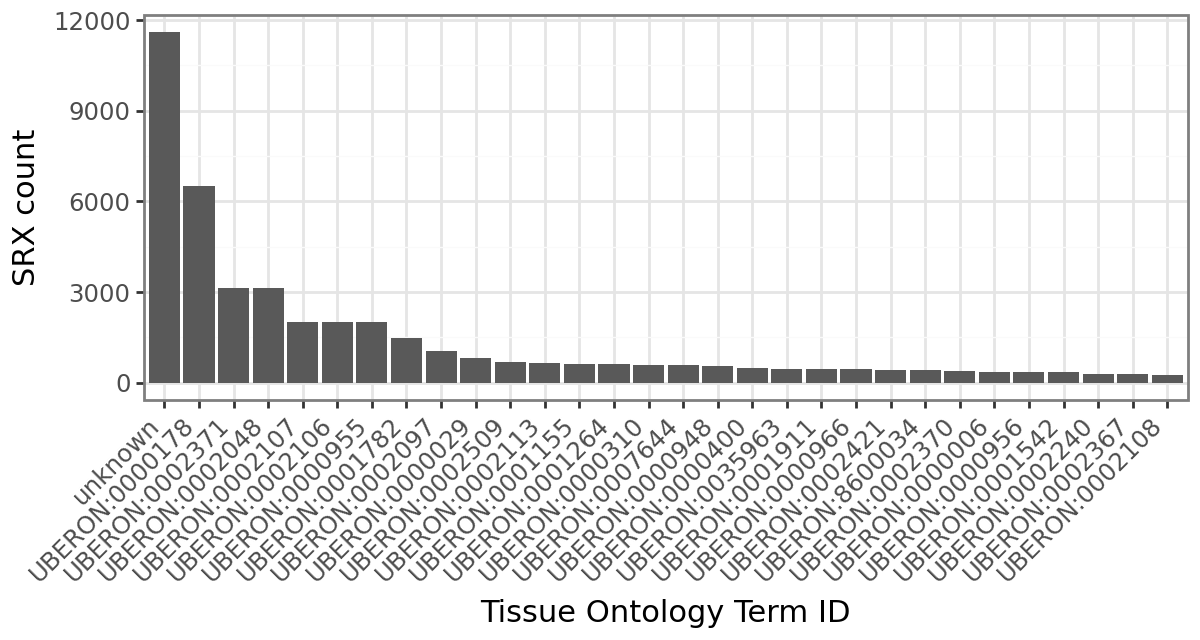

In [70]:
# plot histogram of top 30 tissue ontology term ids
## filter to top 30 categories
top30 = df_srx_meta_exp_cnt.head(30)["tissue_ontology_term_id"].to_list()
df = df_srx_meta_exp[df_srx_meta_exp["tissue_ontology_term_id"].isin(top30)].copy()
df["tissue_ontology_term_id"] = df["tissue_ontology_term_id"].to_list()

## order category by count
df["tissue_ontology_term_id"] = pd.Categorical(
    df["tissue_ontology_term_id"], 
    categories=df["tissue_ontology_term_id"].value_counts().index
)

# plot
p = (
    pn.ggplot(df, pn.aes(x="tissue_ontology_term_id")) +
    pn.geom_bar() +
    pn.labs(x="Tissue Ontology Term ID", y="SRX count") +
    pn.theme(
        axis_text_x=pn.element_text(angle=45, hjust=1),
        figure_size=(6, 3.2)
    )
)
p

# Tissue categories

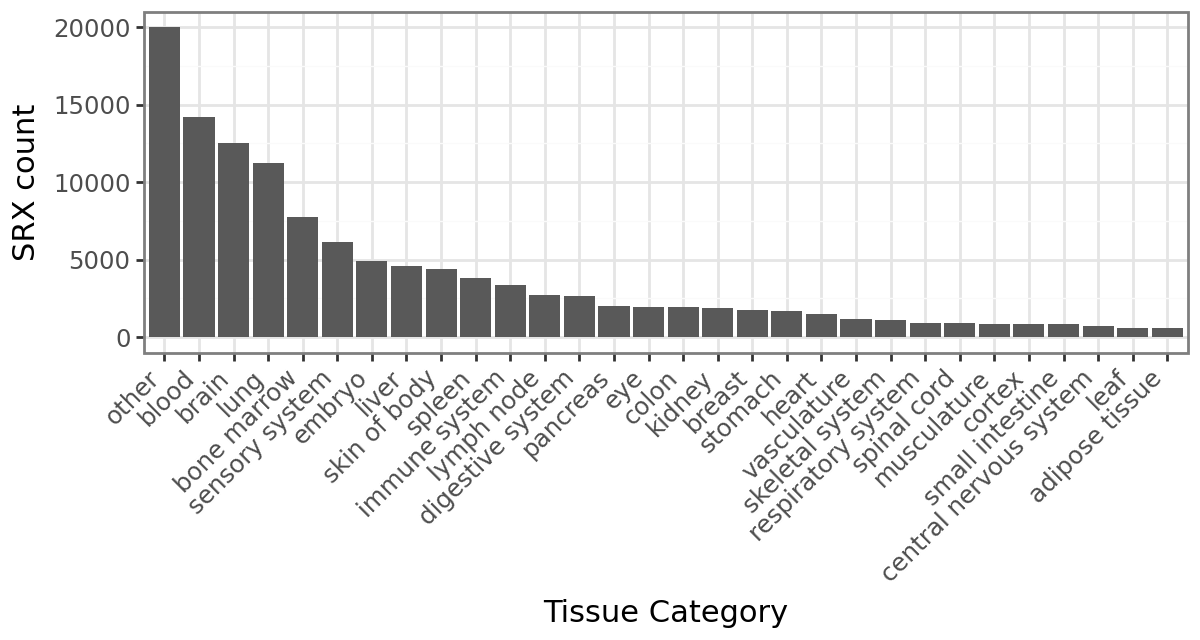

In [55]:
# plot histogram of tissue categories
## filter to top 30 categories
top30 = df_srx_meta["category"].value_counts().head(30).index
df = df_srx_meta[df_srx_meta["category"].isin(top30)].copy()
df["category"] = df["category"].to_list()

## order category by count
df["category"] = pd.Categorical(
    df["category"], 
    categories=df["category"].value_counts().index
)

# plot
p = (
    pn.ggplot(df, pn.aes(x="category")) +
    pn.geom_bar() +
    pn.labs(x="Tissue Category", y="SRX count") +
    pn.theme(
        axis_text_x=pn.element_text(angle=45, hjust=1),
        figure_size=(6, 3.2)
    )
)
p

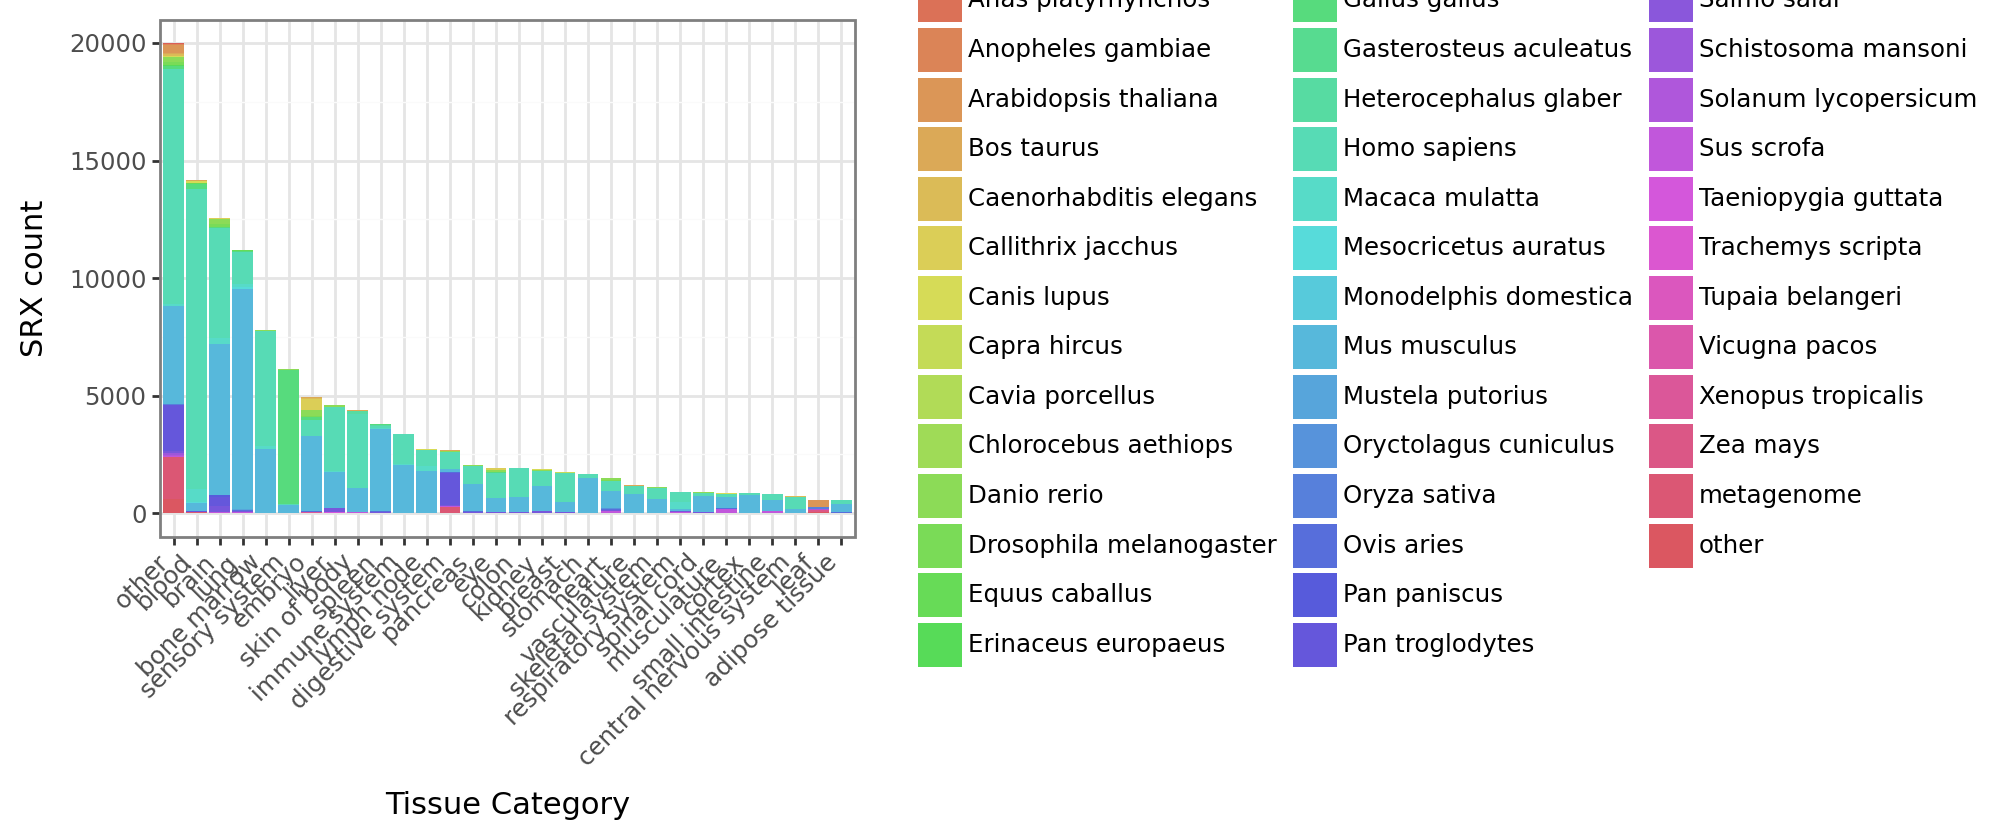

In [56]:
# plot histogram of tissue categories
## filter to top 30 categories
top30 = df_srx_meta["category"].value_counts().head(30).index
df = df_srx_meta[df_srx_meta["category"].isin(top30)].copy()

## order category by count
df["category"] = pd.Categorical(
    df["category"], 
    categories=df["category"].value_counts().index
)

# plot
p = (
    pn.ggplot(df, pn.aes(x="category", fill="organism")) +
    pn.geom_bar() +
    pn.labs(x="Tissue Category", y="SRX count", fill="Organism") +
    pn.theme(
        axis_text_x=pn.element_text(rotation=45, hjust=1),
        figure_size=(10, 4.2),
        legend_key_height=1,
    ) 
)
p

## Animals, except human and mouse

In [87]:
other_animals = ['Macaca mulatta',
 'Sus scrofa',
 'Gallus gallus',
 'Drosophila melanogaster',
 'Equus caballus',
 'Pan troglodytes',
 'Heterocephalus glaber',
 'Callithrix jacchus',
 'Danio rerio',
 'Bos taurus',
 'Caenorhabditis elegans',
 'Oryctolagus cuniculus',
 'Ovis aries',
 'Schistosoma mansoni',
 'Gorilla gorilla']
other_animals

['Macaca mulatta',
 'Sus scrofa',
 'Gallus gallus',
 'Drosophila melanogaster',
 'Equus caballus',
 'Pan troglodytes',
 'Heterocephalus glaber',
 'Callithrix jacchus',
 'Danio rerio',
 'Bos taurus',
 'Caenorhabditis elegans',
 'Oryctolagus cuniculus',
 'Ovis aries',
 'Schistosoma mansoni',
 'Gorilla gorilla']

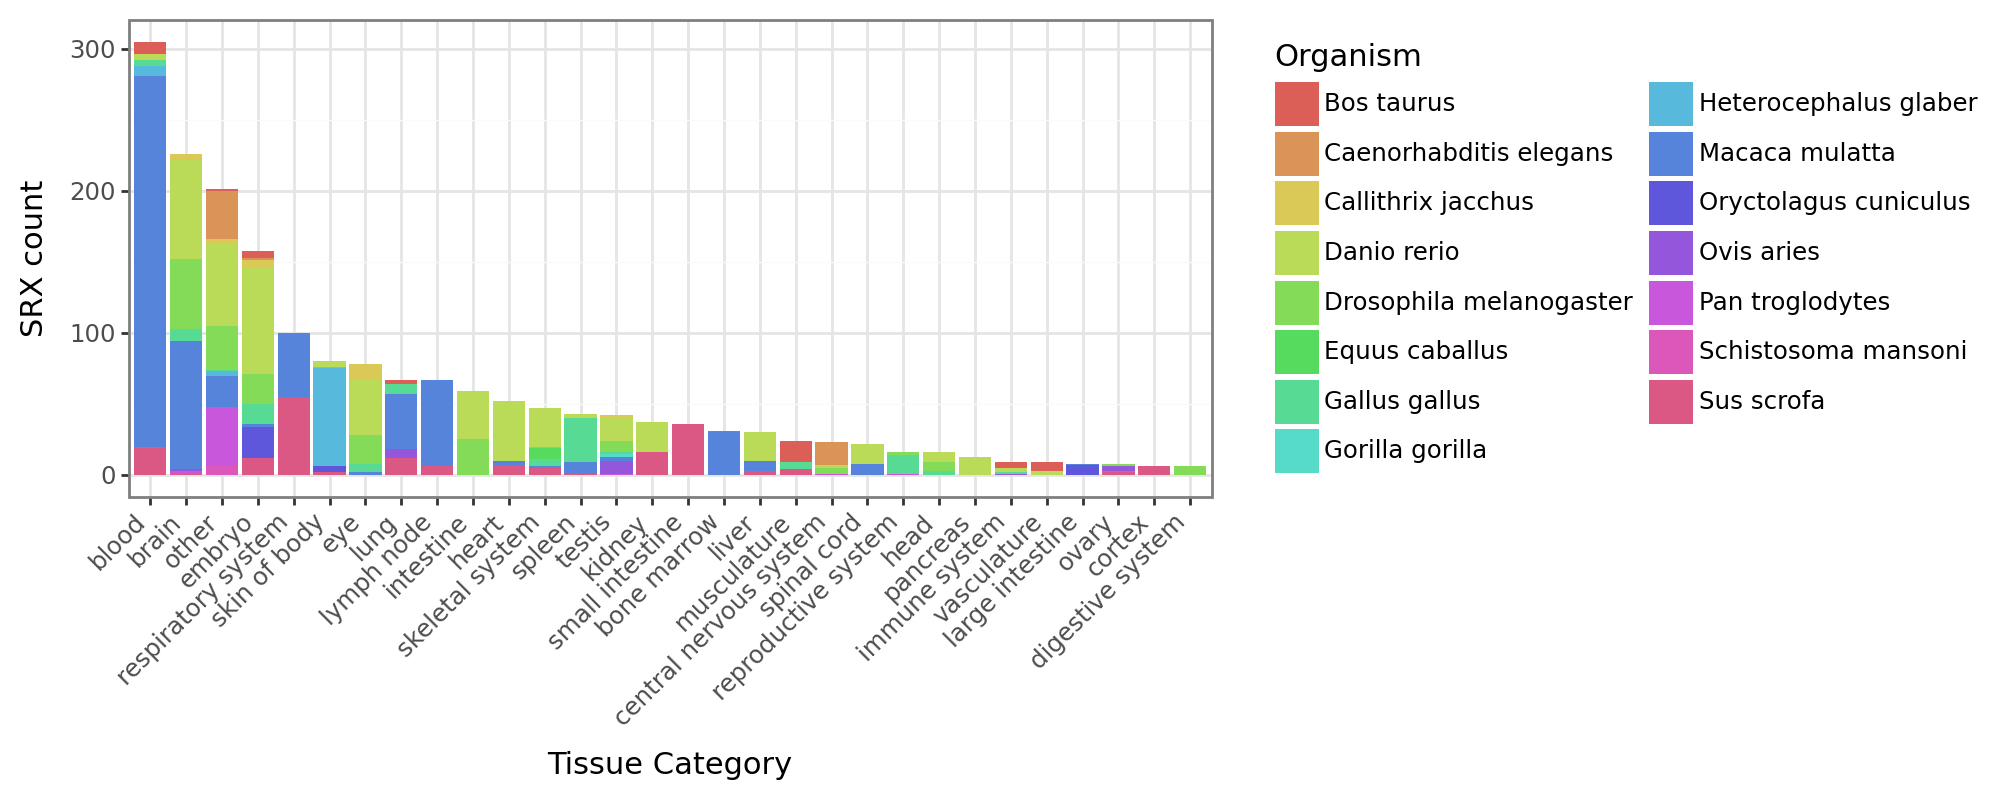

In [100]:
# plot histogram of tissue categories
## filter to target organisms
df = df_srx_meta[df_srx_meta["organism"].isin(other_animals)].copy()

## filter to top 30 categories
top30 = df["category"].value_counts().head(30).index
df = df[df["category"].isin(top30)]
df["category"] = df["category"].tolist()

## order category by count
df["category"] = pd.Categorical(
    df["category"], 
    categories=df["category"].value_counts().index
)

# plot
p = (
    pn.ggplot(df, pn.aes(x="category", fill="organism")) +
    pn.geom_bar() +
    pn.labs(x="Tissue Category", y="SRX count", fill="Organism") +
    pn.theme(
        axis_text_x=pn.element_text(rotation=45, hjust=1),
        figure_size=(10, 4),
    ) +
    pn.guides(fill=pn.guide_legend(ncol=2))
)
p

## Just plants

In [64]:
plants = ["Arabidopsis thaliana", "Oryza sativa", "Solanum lycopersicum", "Zea mays"]

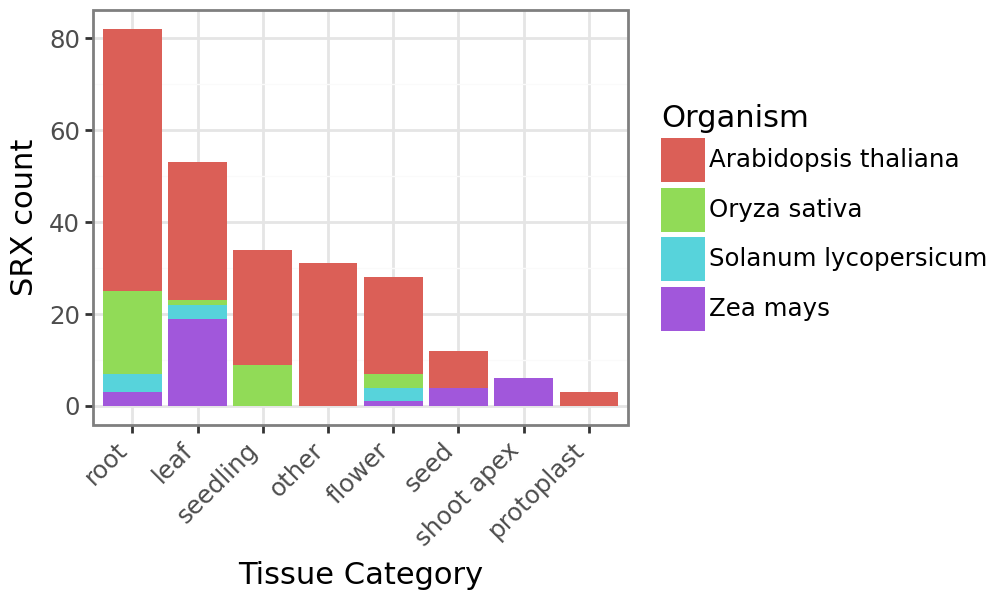

In [71]:
# plot histogram of tissue categories
## filter to plants
df = df_srx_meta[df_srx_meta["organism"].isin(plants)].copy()

## filter to top 30 categories
top30 = df["category"].value_counts().head(30).index
df = df[df["category"].isin(top30)]
df["category"] = df["category"].tolist()

## order category by count
df["category"] = pd.Categorical(
    df["category"], 
    categories=df["category"].value_counts().index
)

# plot
p = (
    pn.ggplot(df, pn.aes(x="category", fill="organism")) +
    pn.geom_bar() +
    pn.labs(x="Tissue Category", y="SRX count", fill="Organism") +
    pn.theme(
        axis_text_x=pn.element_text(rotation=45, hjust=1),
        figure_size=(5, 3),
        legend_key_height=1,
    ) 
)
p